# |This notebook only shows basic usage of ICA methods in MNE library


In [11]:
import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(project_root)

print(project_root)

import mne
from data_processing import data_processing as dp
from mne.preprocessing import ICA

/Users/gsk/documents/projects/Lie-Detector/classificators_and_data


In [5]:

dir_path = '../../data'

file_paths = dp.get_file_paths(dir_path)
print(file_paths)


['../../data/1299BF1A/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif', '../../data/1299BF1A/EEG_ExperimentBlock.HONEST_RESPONSE_TO_TRUE_IDENTITY_raw.fif', '../../data/1299BF1A/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_TRUE_IDENTITY_raw.fif', '../../data/1299BF1A/EEG_ExperimentBlock.HONEST_RESPONSE_TO_FAKE_IDENTITY_raw.fif', '../../data/DAF24E45/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif', '../../data/DAF24E45/EEG_ExperimentBlock.HONEST_RESPONSE_TO_TRUE_IDENTITY_raw.fif', '../../data/DAF24E45/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_TRUE_IDENTITY_raw.fif', '../../data/DAF24E45/EEG_ExperimentBlock.HONEST_RESPONSE_TO_FAKE_IDENTITY_raw.fif', '../../data/827366EC/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif', '../../data/827366EC/EEG_ExperimentBlock.HONEST_RESPONSE_TO_TRUE_IDENTITY_raw.fif', '../../data/827366EC/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_TRUE_IDENTITY_raw.fif', '../../data/827366EC/EEG_ExperimentBlock.HONEST_RESPONSE_

In [6]:
example_file = file_paths[0]
raw = mne.io.read_raw_fif(example_file, preload=True)
raw.filter(1., 40., fir_design='firwin')

Opening raw data file ../../data/1299BF1A/EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif...


    Range : 0 ... 70649 =      0.000 ...   282.596 secs
Ready.
Reading 0 ... 70649  =      0.000 ...   282.596 secs...
Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)



<Raw | EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif, 21 x 70650 (282.6 s), ~11.3 MB, data loaded>

In [7]:
raw.apply_function(fun=lambda x: x * 10**-6)

<Raw | EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif, 21 x 70650 (282.6 s), ~11.3 MB, data loaded>

In [8]:
raw.pick_types(meg=False, eeg=True, eog=False, stim=False)

NOTE: pick_types() is a legacy function. New code should use inst.pick(...).


<Raw | EEG_ExperimentBlock.DECEITFUL_RESPONSE_TO_FAKE_IDENTITY_raw.fif, 16 x 70650 (282.6 s), ~8.6 MB, data loaded>

Using matplotlib as 2D backend.


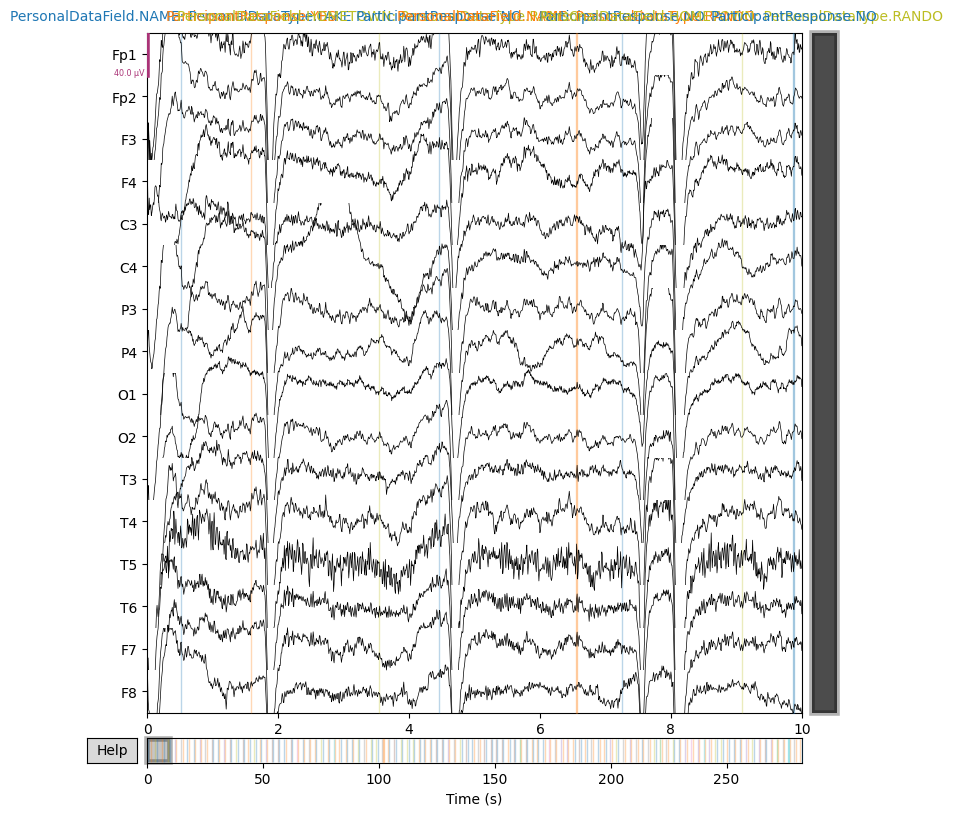

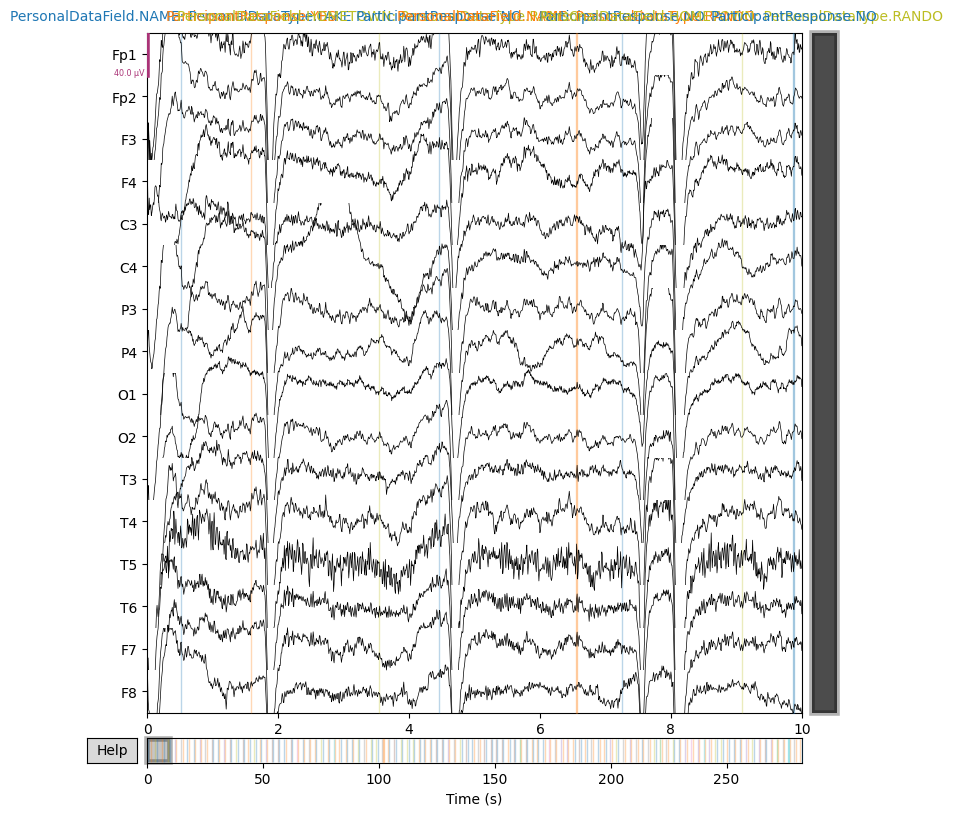

In [9]:
raw.plot()

In [12]:
ica = ICA(n_components=len(raw.ch_names), random_state=97, max_iter='auto')
ica.fit(raw)

Fitting ICA to data using 16 channels (please be patient, this may take a while)
Selecting by number: 16 components
Fitting ICA took 0.4s.


<ICA | raw data decomposition, method: fastica (fit in 22 iterations on 70650 samples), 16 ICA components (16 PCA components available), channel types: eeg, no sources marked for exclusion>

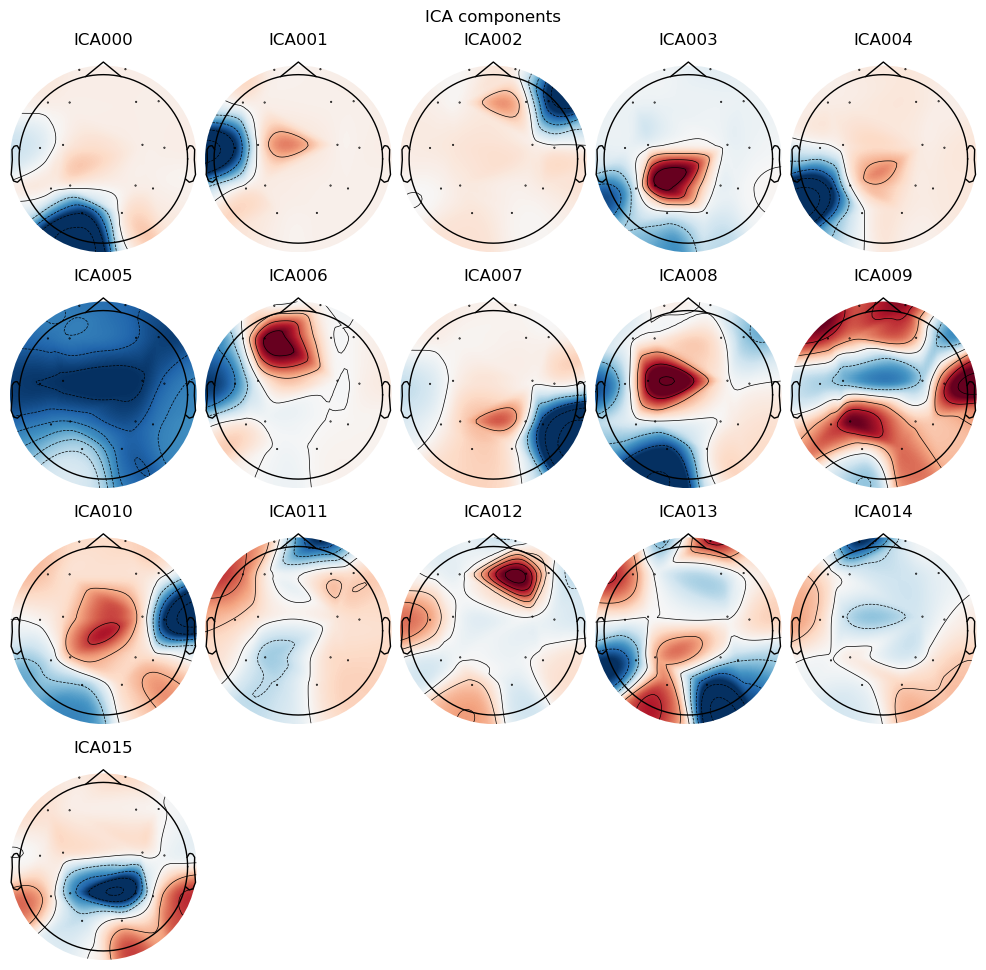

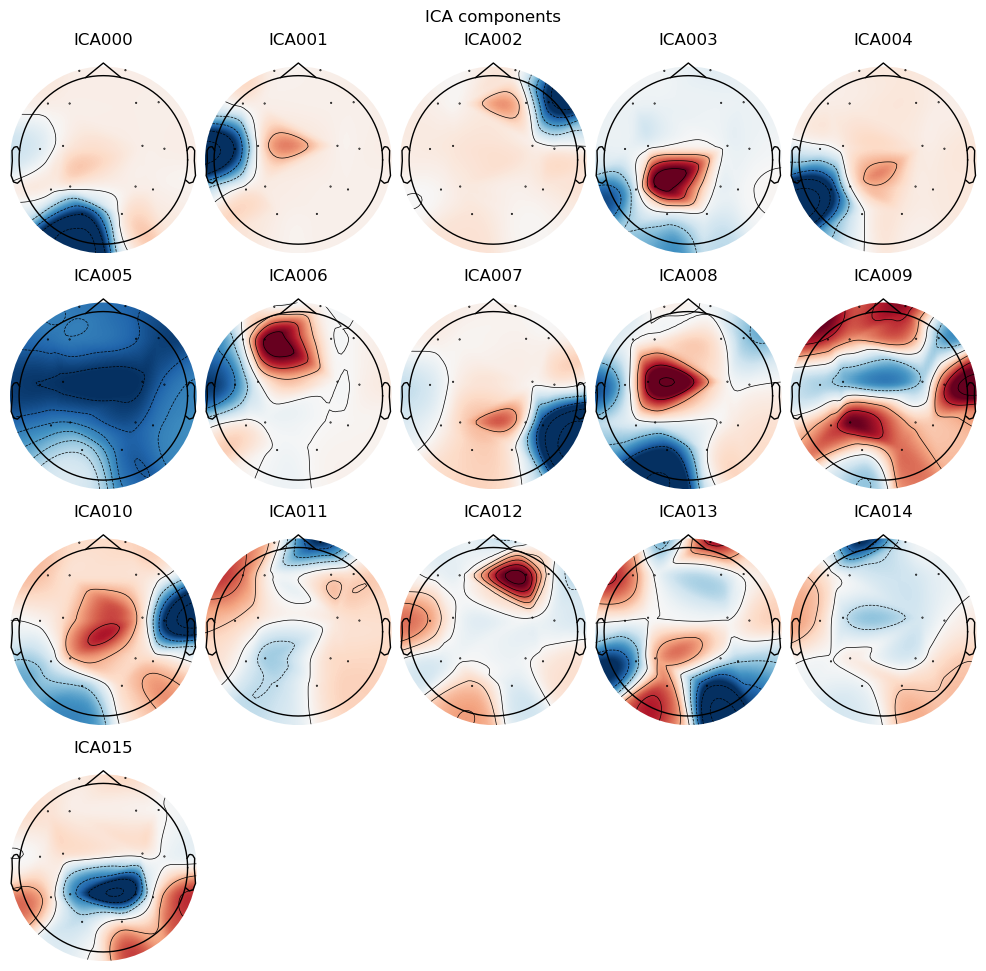

In [49]:
ica.plot_components()

In [50]:
ica.plot_sources(raw)

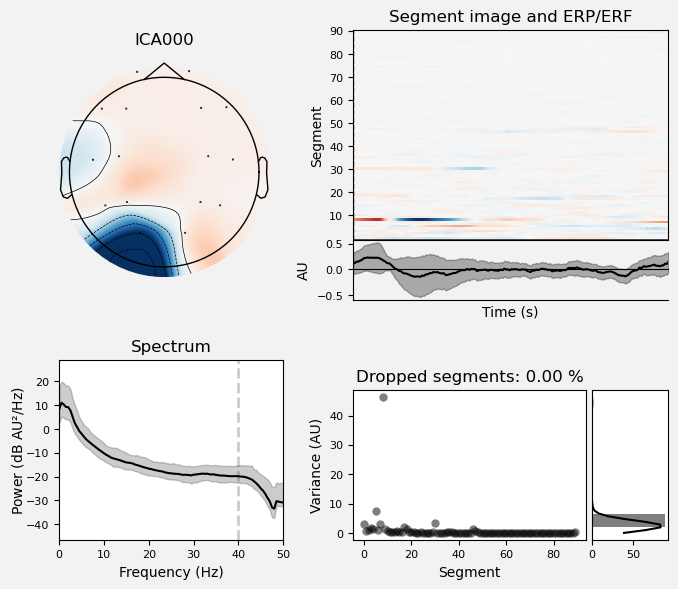

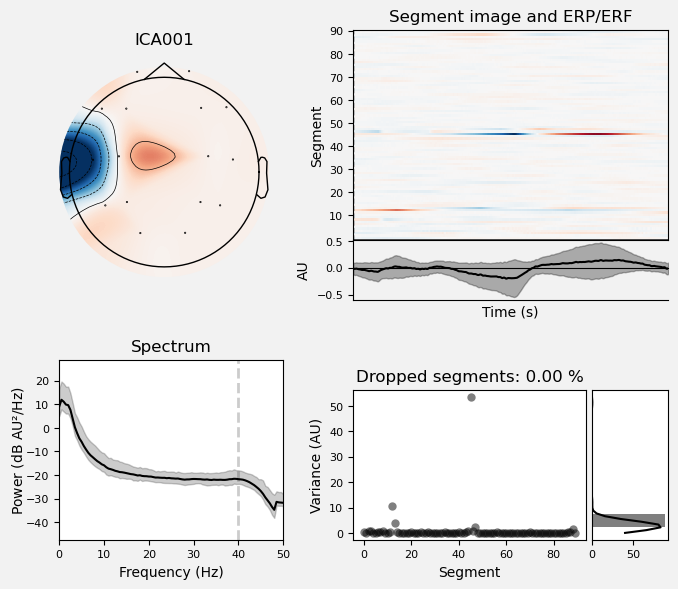

[<Figure size 700x600 with 6 Axes>, <Figure size 700x600 with 6 Axes>]

In [51]:
bad_inds = [0, 1]

ica.plot_properties(raw, picks=bad_inds)

In [52]:
# Exclude the bad components and apply the ICA solution to the raw data
# ica.exclude = bad_inds
ica.apply(raw)

<Raw | GS001.fif, 16 x 45000 (180.0 s), ~5.5 MB, data loaded>

In [53]:
ica.exclude = bad_inds
ica.apply(raw)

<Raw | GS001.fif, 16 x 45000 (180.0 s), ~5.5 MB, data loaded>

In [54]:
raw.plot()

In [61]:
ica.save('ica_solution.fif', overwrite=True)
raw.save('cleaned_raw.fif', overwrite=True)

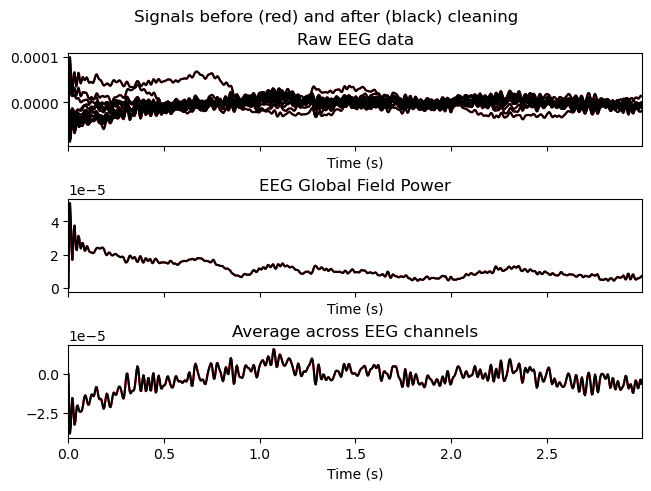

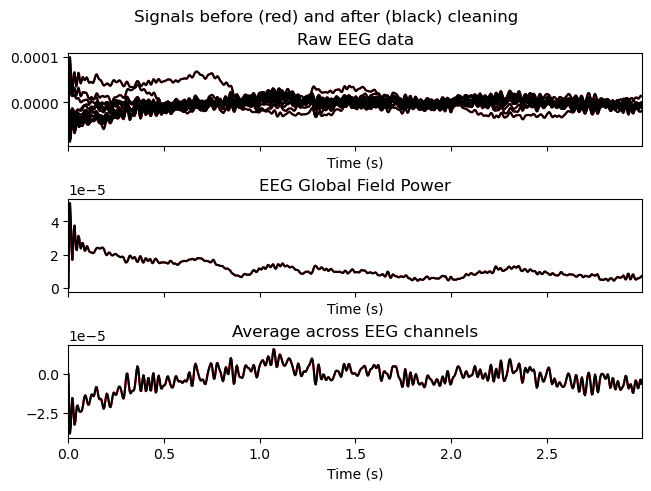

In [56]:
ica.plot_overlay(raw)

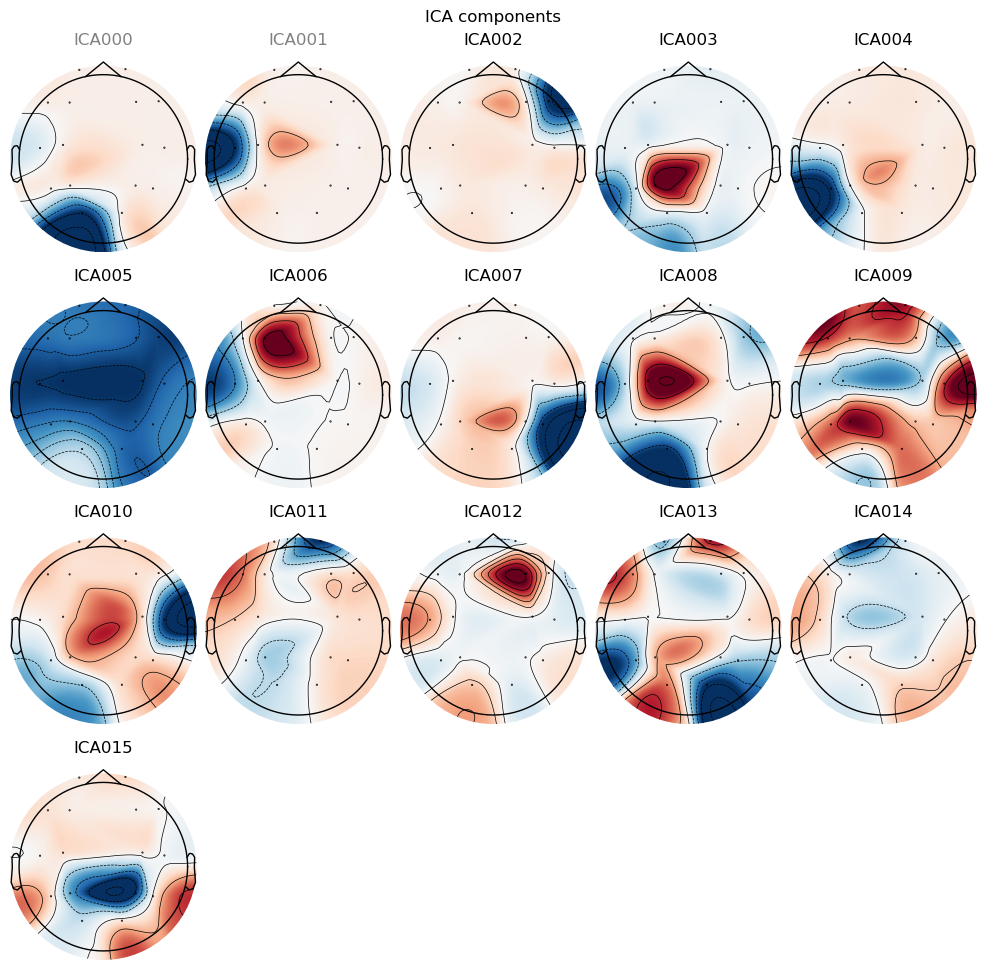

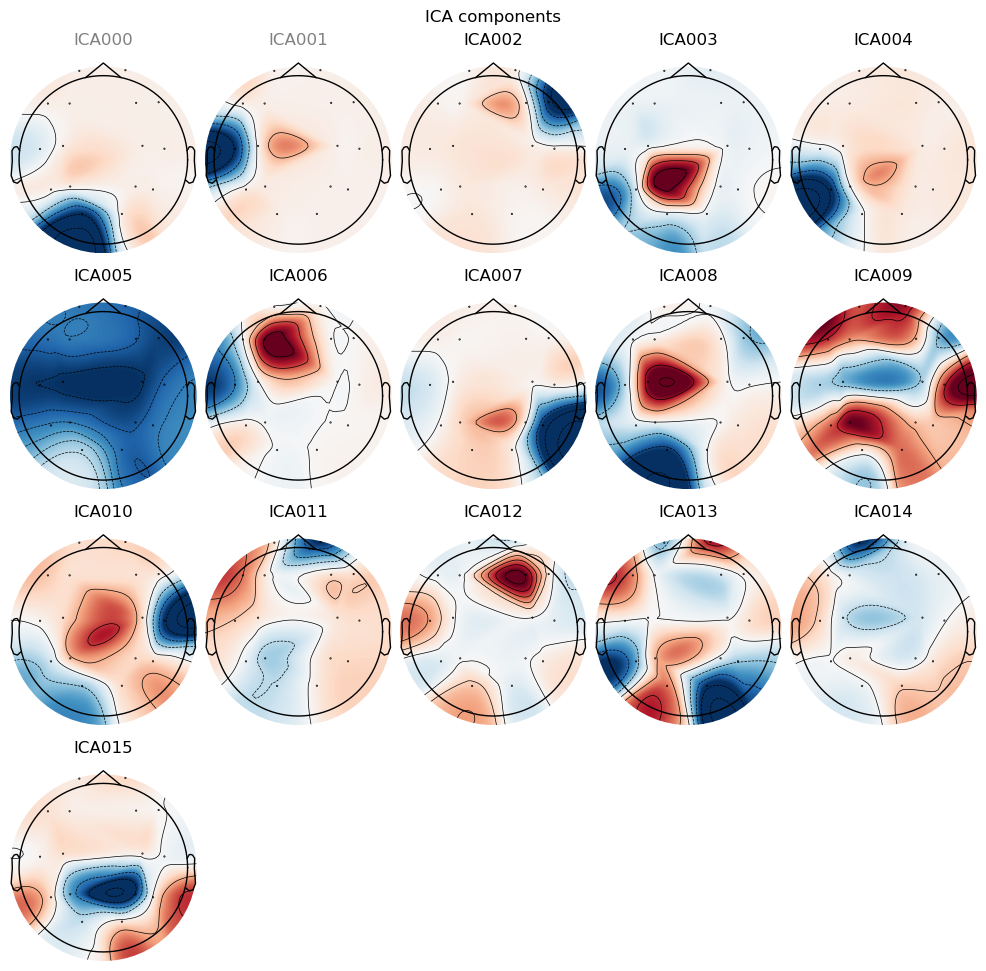

In [57]:
ica.plot_components(inst=raw, ch_type='eeg')

In [58]:
import pandas as pd

ica_sources = ica.get_sources(raw).get_data()

# Create a DataFrame from ICA component activations
ica_df = pd.DataFrame(ica_sources.T, columns=[f'ICA_{i}' for i in range(ica_sources.shape[0])])

In [66]:
raw_ica = ica.apply(raw.copy()) 

In [67]:
events, event_dict = mne.events_from_annotations(raw_ica)

epochs = mne.Epochs(raw_ica, events, event_dict, tmin=-0.2, tmax=0.5, baseline=(None, 0), preload=True)